# Downstream spatial analysis 03
- Calculate distances to individual cell types for each cell 



In [1]:
import sys
import os
import time
import warnings
import re
import math
import hisepy as hp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import scanpy as sc
import squidpy as sq


import scipy
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist
from scipy import stats
import scipy.ndimage as ndi
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks

from shapely.geometry import Point

sys.version_info

sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)

In [2]:
import random
import matplotlib.colors as mcolors

In [3]:
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 24

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

In [5]:
from shapely.geometry import MultiPolygon
from alphashape import alphashape
from alphashape import optimizealpha
import geopandas as gpd

import pickle
import joblib

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [7]:
import matplotlib.colors as clr
import colorcet

zissou = [
    "#3A9AB2",
    "#6FB2C1",
    "#91BAB6",
    "#A5C2A3",
    "#BDC881",
    "#DCCB4E",
    "#E3B710",
    "#E79805",
    "#EC7A05",
    "#EF5703",
    "#F11B00",
]

colormap = clr.LinearSegmentedColormap.from_list("Zissou", zissou)
colormap_r = clr.LinearSegmentedColormap.from_list("Zissou", zissou[::-1])

## Active environment:

In [8]:
print('active conda environment: ', os.path.basename(sys.prefix))

active conda environment:  space2


## Local file info

In [9]:
dist_out_dir = '/home/workspace/spatial_mouse_lung_outputs/downstream_analysis/distance'

if not os.path.exists (dist_out_dir):
    os.makedirs(dist_out_dir)

plot_out_dir = os.path.join(dist_out_dir, 'plots')
if not os.path.exists (plot_out_dir):
    os.makedirs(plot_out_dir)

## Load adata

In [79]:
xen_filepath = os.path.join(dist_out_dir,'adata_distance_zones_structure.h5ad')
adata = sc.read_h5ad(xen_filepath)

## Load palettes

In [80]:
with open(os.path.join(dist_out_dir, '20250519_celltype_palette_mapped.pkl'), 'rb') as f:
    celltype_palette_mapped = pickle.load(f)

with open(os.path.join(dist_out_dir, '20250520_celltype_palette_coarse_mapped.pkl'), 'rb') as f:
    celltype_palette_coarse_mapped = pickle.load(f)

with open(os.path.join(dist_out_dir, '20250520_celltype_palette_coarser_mapped.pkl'), 'rb') as f:
    celltype_palette_coarser_mapped = pickle.load(f)

with open(os.path.join(dist_out_dir, '20250521_zone_consol_palette_mapped.pkl'), 'rb') as f:
    zone_consol_palette_mapped = pickle.load(f)

# Calculate distance of each cell to all other cell types

In [82]:
def cell_dist_to_other_celltype(adata, cell_type_col, other_cell_type_col, other_cell_type, nearest_n):
    
    # get coordinates of other cell type (the one we want to calculate the distance to)
    adata_other_type = adata[adata.obs[other_cell_type_col] == other_cell_type, :]
    other_cell_type_coords = adata_other_type.obs[['x_centroid', 'y_centroid']].values
    # print('adata_other_type shape ', adata_other_type.shape)
    
    # Iterate over each unique cell type
    for cell_type in adata.obs[cell_type_col].unique():
        print(cell_type)
        
        # Filter AnnData object for the current cell type
        adata_filtered = adata[adata.obs[cell_type_col] == cell_type, :]
        adata_filtered_cell_type_indices = adata_filtered.obs.index
        # print('adata_cell_type shape ', adata_filtered.shape)
    
        # Get the coordinates of the cells of the current type
        cell_type_coords = adata_filtered.obs[['x_centroid', 'y_centroid']].values
        
        # Calculate the pairwise distances between the current cell type and other cell type
        pairwise_distances = cdist(cell_type_coords, other_cell_type_coords, metric='euclidean')
    
        # Sort distances and select nearest n
        nearest_distances = np.sort(pairwise_distances, axis=1)[:, :nearest_n]
        
        # Calculate the average distance to the nearest n cells
        avg_distance = np.mean(nearest_distances, axis=1)

        # Store distances in adata.obs 

        # column name to store distance to other type
        dist_col = f'avg_distance_to_{other_cell_type}_n{nearest_n}'
        
        # Assigning values to the new column in the original DataFrame, using cell type filtered adata indices
        adata.obs.loc[adata_filtered_cell_type_indices, dist_col] = avg_distance

    return adata

In [83]:
# adata_original = adata.copy()

In [84]:
# # test on subsample 
# adata = sc.pp.subsample(adata_original, n_obs=10000, copy=True)

# make all CD4 act one label 
adata.obs['label_for_int'] = adata.obs['label_fine'].copy()
adata.obs['label_for_int'] = adata.obs['label_for_int'].replace('Th0', 'CD4 act')
adata.obs['label_for_int'] = adata.obs['label_for_int'].replace('Th1', 'CD4 act')
adata.obs['label_for_int'] = adata.obs['label_for_int'].replace('Th17', 'CD4 act')
adata.obs['label_for_int'] = adata.obs['label_for_int'].replace('Th2', 'CD4 act')
adata.obs['label_for_int'] = adata.obs['label_for_int'].replace('Treg', 'CD4 act')
adata.obs['label_for_int'] = adata.obs['label_for_int'].replace('CD4 trans', 'CD4 act')

# set columns for dist calculation 
cell_type_col = 'label_for_int'
other_cell_type_col = 'label_for_int'
nearest_n = 1

# for sample_label in adata.obs['sample_label'].cat.categories:
sample_label = 'HDM_day3'
print(sample_label)

adata_sample = adata[adata.obs['sample_label']==sample_label, :]

start_time = time.time()

distance_cols = []

for other_cell_type in adata_sample.obs[other_cell_type_col].cat.categories:

    print(other_cell_type)

    dist_col = f'avg_distance_to_{other_cell_type}_n{nearest_n}'
    distance_cols.append(dist_col)
    adata_sample.obs[dist_col] = np.nan

    # run distance calculation 
    adata_sample = cell_dist_to_other_celltype(adata_sample, cell_type_col, other_cell_type_col, other_cell_type, nearest_n)
    
    # get distance df for each distance and add it back to the main adata object
    dist_df = adata_sample.obs[[dist_col]] 
    adata_sample.obs.loc[dist_df.index, dist_col] = dist_df[dist_col]
    adata_sample.obs[dist_col] = pd.to_numeric(adata_sample.obs[dist_col])
    
end_time = time.time()
elapsed_time = (end_time - start_time) / 60
print(elapsed_time, ' min')


# Extract distance cols to save as df
distance_cols_df = adata_sample.obs[distance_cols]
# Save to CSV
distance_cols_df.to_csv(os.path.join(dist_out_dir, f"celltype_dist_n{nearest_n}_{sample_label}.csv"), index=True)

HDM_day3
AT1
AT2
CD4 naive
CD4 act
Col13a1+ fibroblast
AT1
Cap-a
Alv Mf
B cell
Int Mf
Cap
Neut
cDC1
SMC
gd T cell
ILC2
AT2
AT2
CD4 naive
CD4 act
Col13a1+ fibroblast
AT1
Cap-a
Alv Mf
B cell
Int Mf
Cap
Neut
cDC1
SMC
gd T cell
Mono
Pericyte 2
NK cell
Vein
CD8 naive
Plasmablast
CD8 act
Ccr7+ cDC2
Lymph
Mesothelial
Art
Myofibroblast
Ccr7- cDC2
Pericyte 1
Club
Ciliated
Col14a1+ fibroblast
ILC2
Club
AT2
CD4 naive
CD4 act
Col13a1+ fibroblast
AT1
Cap-a
Alv Mf
B cell
Int Mf
Cap
Neut
cDC1
SMC
gd T cell
Mono
Pericyte 2
NK cell
Vein
CD8 naive
Plasmablast
CD8 act
Ccr7+ cDC2
Lymph
Mesothelial
Art
Myofibroblast
Ccr7- cDC2
Pericyte 1
Club
Ciliated
Col14a1+ fibroblast
ILC2
Ciliated
AT2
CD4 naive
CD4 act
Col13a1+ fibroblast
AT1
Cap-a
Alv Mf
B cell
Int Mf
Cap
Neut
cDC1
SMC
gd T cell
Mono
Pericyte 2
NK cell
Vein
CD8 naive
Plasmablast
CD8 act
Ccr7+ cDC2
Lymph
Mesothelial
Art
Myofibroblast
Ccr7- cDC2
Pericyte 1
Club
Ciliated
Col14a1+ fibroblast
ILC2
SMC
AT2
CD4 naive
CD4 act
Col13a1+ fibroblast
AT1
Cap-a
Alv

## Plot distances to cell types

In [88]:
# distance_cols

In [101]:
summary_cd4

,label_for_int,zone_consol,avg_distance_to_AT1_n1,avg_distance_to_AT2_n1,avg_distance_to_Club_n1,avg_distance_to_Ciliated_n1,avg_distance_to_SMC_n1,avg_distance_to_Col13a1+ fibroblast_n1,avg_distance_to_Col14a1+ fibroblast_n1,avg_distance_to_Myofibroblast_n1,...,avg_distance_to_Ccr7+ cDC2_n1,avg_distance_to_B cell_n1,avg_distance_to_Plasmablast_n1,avg_distance_to_NK cell_n1,avg_distance_to_gd T cell_n1,avg_distance_to_ILC2_n1,avg_distance_to_CD8 naive_n1,avg_distance_to_CD8 act_n1,avg_distance_to_CD4 naive_n1,avg_distance_to_CD4 act_n1
217,CD4 act,TLS,49.123246,29.286589,281.771945,305.246418,57.155659,37.912057,25.360243,170.248064,...,50.564398,5.876783,31.673313,82.857021,14.708004,361.096251,116.776943,36.533484,62.015954,0.0
218,CD4 act,TLS-small,31.163534,14.788824,238.727331,258.158428,45.800338,27.239163,36.916407,175.512250,...,59.575731,12.883959,63.722999,75.901950,18.123854,348.121011,97.938296,47.442439,58.140359,0.0
219,CD4 act,bronchi,41.120246,43.800743,10.001717,13.969602,47.196687,51.343594,43.017930,34.206243,...,135.445300,51.388866,100.920806,106.415219,30.722499,344.037956,165.729667,86.713706,51.686971,0.0
220,CD4 act,vessels,58.176617,42.178570,206.445011,253.320206,59.072999,43.946005,30.367197,137.913363,...,67.626180,35.059849,63.914520,89.201327,24.887045,332.818739,110.352348,55.832655,85.160924,0.0
221,CD4 act,adventitia,42.090569,25.292598,165.062077,184.253954,45.776961,31.032779,20.667732,129.448586,...,77.100062,25.751467,69.789484,89.122989,17.413845,366.515217,112.420199,54.752371,73.504361,0.0
222,CD4 act,parenchyma,26.688217,14.652272,298.036386,320.346381,51.810938,20.610126,89.025432,224.330162,...,101.877847,27.524449,117.579524,64.292529,36.992985,365.048896,82.264793,57.147928,61.021705,0.0
223,CD4 act,capsule,29.153970,15.364147,612.368815,682.372818,55.278111,15.934555,58.048734,416.127364,...,168.497426,36.978762,163.375872,79.607528,33.712443,391.649163,116.930611,83.008117,97.748951,0.0


In [104]:
summary_cd4_norm

,label_for_int,zone_consol,avg_distance_to_AT1_n1,avg_distance_to_AT2_n1,avg_distance_to_Club_n1,avg_distance_to_Ciliated_n1,avg_distance_to_SMC_n1,avg_distance_to_Col13a1+ fibroblast_n1,avg_distance_to_Col14a1+ fibroblast_n1,avg_distance_to_Myofibroblast_n1,...,avg_distance_to_Ccr7+ cDC2_n1,avg_distance_to_B cell_n1,avg_distance_to_Plasmablast_n1,avg_distance_to_NK cell_n1,avg_distance_to_gd T cell_n1,avg_distance_to_ILC2_n1,avg_distance_to_CD8 naive_n1,avg_distance_to_CD8 act_n1,avg_distance_to_CD4 naive_n1,avg_distance_to_CD4 act_n1
217,CD4 act,TLS,0.177010,0.157995,0.155468,0.151287,0.157849,0.166268,0.083586,0.132202,...,0.076533,0.030066,0.051840,0.141058,0.083303,0.143904,0.145532,0.086689,0.126750,NaN
218,CD4 act,TLS-small,0.112294,0.079783,0.131718,0.127949,0.126488,0.119460,0.121674,0.136290,...,0.090172,0.065915,0.104297,0.129217,0.102649,0.138733,0.122055,0.112575,0.118829,NaN
219,CD4 act,bronchi,0.148172,0.236296,0.005518,0.006924,0.130345,0.225173,0.141784,0.026562,...,0.205007,0.262907,0.165180,0.181164,0.174005,0.137106,0.206539,0.205760,0.105639,NaN
220,CD4 act,vessels,0.209633,0.227545,0.113906,0.125551,0.163144,0.192730,0.100088,0.107093,...,0.102357,0.179367,0.104610,0.151858,0.140955,0.132635,0.137526,0.132484,0.174054,NaN
221,CD4 act,adventitia,0.151669,0.136448,0.091073,0.091320,0.126424,0.136098,0.068120,0.100520,...,0.116697,0.131745,0.114226,0.151725,0.098628,0.146063,0.140103,0.129920,0.150230,NaN
222,CD4 act,parenchyma,0.096168,0.079046,0.164442,0.158771,0.143088,0.090388,0.293422,0.174198,...,0.154200,0.140816,0.192445,0.109453,0.209520,0.145479,0.102522,0.135605,0.124718,NaN
223,CD4 act,capsule,0.105053,0.082886,0.337875,0.338199,0.152663,0.069883,0.191325,0.323134,...,0.255034,0.189184,0.267401,0.135526,0.190940,0.156080,0.145724,0.196967,0.199782,NaN


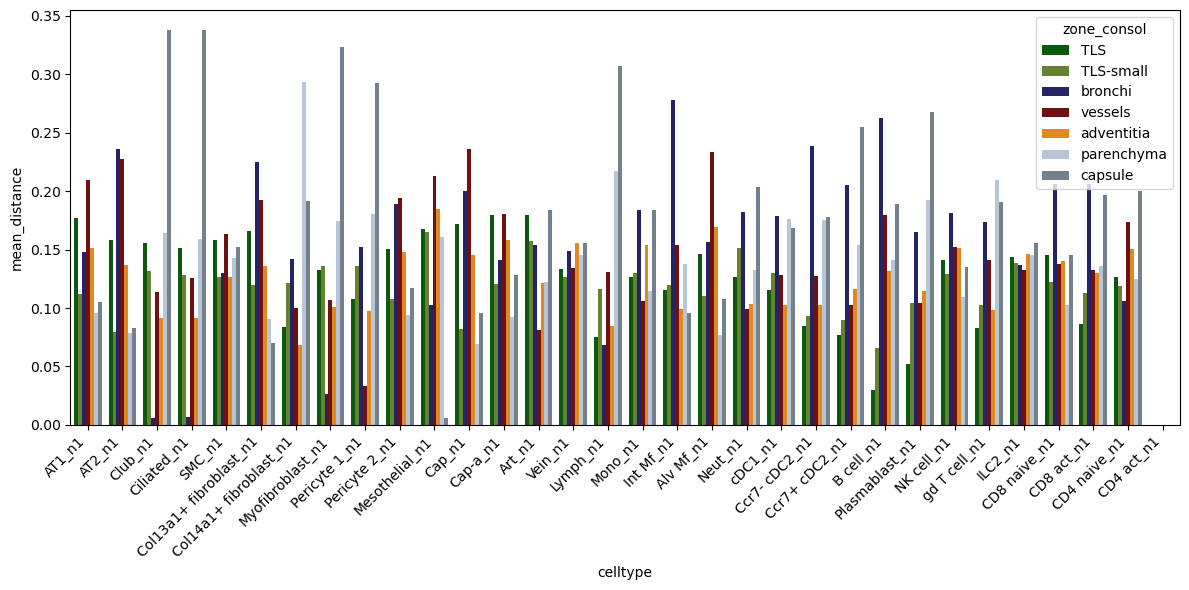

In [120]:
group_by = ['label_for_int', 'zone_consol']
summary = (
    adata_sample.obs[group_by + distance_cols]
    .groupby(group_by)
    .agg('mean')  # or .agg(np.mean)
    .reset_index()
)
summary

summary_cd4 = summary[summary['label_for_int']=='CD4 act']
summary_cd4

# normalize
numeric_cols = [col for col in summary_cd4.columns if col not in group_by]

# Column-normalize only the numeric part
col_sums = summary_cd4[numeric_cols].sum(axis=0)
normalized_numeric = summary_cd4[numeric_cols].div(col_sums, axis=1)

# Combine back with categorical columns
summary_cd4_norm = pd.concat([summary_cd4[categorical_cols], normalized_numeric], axis=1)


summary_melt = summary_cd4_norm.melt(id_vars='zone_consol', 
                           value_vars=distance_cols, 
                           var_name='celltype', 
                           value_name='mean_distance')
summary_melt['celltype'] = summary_melt['celltype'].str.replace('avg_distance_to_', '')
summary_melt

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_melt, x='celltype', y='mean_distance', hue='zone_consol', palette = zone_consol_palette_mapped)
plt.xticks(rotation=45, ha='right')
# plt.title(f'Mean distance to other cell types\n(label_for_int = {label_of_interest})')
# plt.ylim(0,100)
plt.tight_layout()
plt.show()



In [108]:
summary_cd4

,label_fine,zone_consol,avg_distance_to_AT1_n1,avg_distance_to_AT2_n1,avg_distance_to_Club_n1,avg_distance_to_Ciliated_n1,avg_distance_to_SMC_n1,avg_distance_to_Col13a1+ fibroblast_n1,avg_distance_to_Col14a1+ fibroblast_n1,avg_distance_to_Myofibroblast_n1,...,avg_distance_to_Ccr7+ cDC2_n1,avg_distance_to_B cell_n1,avg_distance_to_Plasmablast_n1,avg_distance_to_NK cell_n1,avg_distance_to_gd T cell_n1,avg_distance_to_ILC2_n1,avg_distance_to_CD8 naive_n1,avg_distance_to_CD8 act_n1,avg_distance_to_CD4 naive_n1,avg_distance_to_CD4 act_n1
5,Th0,parenchyma,26.793336,15.131877,287.406124,309.383642,54.989725,20.298901,86.781259,223.562369,...,98.511215,23.375772,114.463368,64.305387,36.455826,371.750296,80.610542,59.533040,57.713283,0.0
12,CD4 trans,parenchyma,26.890342,14.843097,291.377274,313.946926,51.617409,20.120550,91.964956,224.111885,...,108.922199,29.425532,122.656046,66.884073,39.404356,364.415650,82.868775,59.700019,61.500385,0.0
19,Th1,parenchyma,27.875751,14.973040,291.574639,316.772502,54.478287,21.194732,93.114392,222.280292,...,100.620049,27.858872,122.346040,61.778883,37.597730,363.599715,80.331946,49.674263,59.659390,0.0
26,Th17,parenchyma,25.899787,14.175333,296.315614,316.264328,51.599295,21.101348,88.791570,221.958579,...,100.413287,26.743786,113.578143,63.417879,36.417014,367.448610,82.028005,56.904210,60.712956,0.0
33,Th2,parenchyma,27.003269,14.957101,331.414647,352.536827,53.956856,19.191590,91.607525,227.798742,...,111.921284,30.001343,122.467849,65.222880,41.022987,358.286659,83.420892,62.219845,64.095202,0.0
40,Treg,parenchyma,27.193458,14.768019,300.879728,326.704465,48.868841,20.945109,84.159991,228.289551,...,93.158800,27.275531,115.848061,63.163625,33.174035,362.103293,82.916087,53.689870,61.623730,0.0


In [1]:
adata_sample_cd4 = adata_sample[adata_sample.obs['label_medium']=='CD4 act', :]

group_by = ['label_fine', 'zone_consol']
summary_cd4 = (
    adata_sample_cd4.obs[group_by + distance_cols]
    .groupby(group_by)
    .agg('mean')  # or .agg(np.mean)
    .reset_index()
)
summary

summary_cd4 = summary_cd4[summary_cd4['zone_consol']=='adventitia']
summary_cd4

# normalize
numeric_cols = [col for col in summary_cd4.columns if col not in group_by]

# Column-normalize only the numeric part
col_sums = summary_cd4[numeric_cols].sum(axis=0)
normalized_numeric = summary_cd4[numeric_cols].div(col_sums, axis=1)

# Combine back with categorical columns
summary_cd4_norm = pd.concat([summary_cd4[group_by], normalized_numeric], axis=1)


summary_melt = summary_cd4.melt(id_vars='label_fine', 
                           value_vars=distance_cols, 
                           var_name='celltype', 
                           value_name='mean_distance')
summary_melt['celltype'] = summary_melt['celltype'].str.replace('avg_distance_to_', '')
summary_melt

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_melt, x='celltype', y='mean_distance', hue='label_fine', palette = celltype_palette_mapped)
plt.xticks(rotation=45, ha='right')
# plt.title(f'Mean distance to other cell types\n(label_for_int = {label_of_interest})')
# plt.ylim(0,100)
plt.tight_layout()
plt.show()



NameError: name 'adata_sample' is not defined

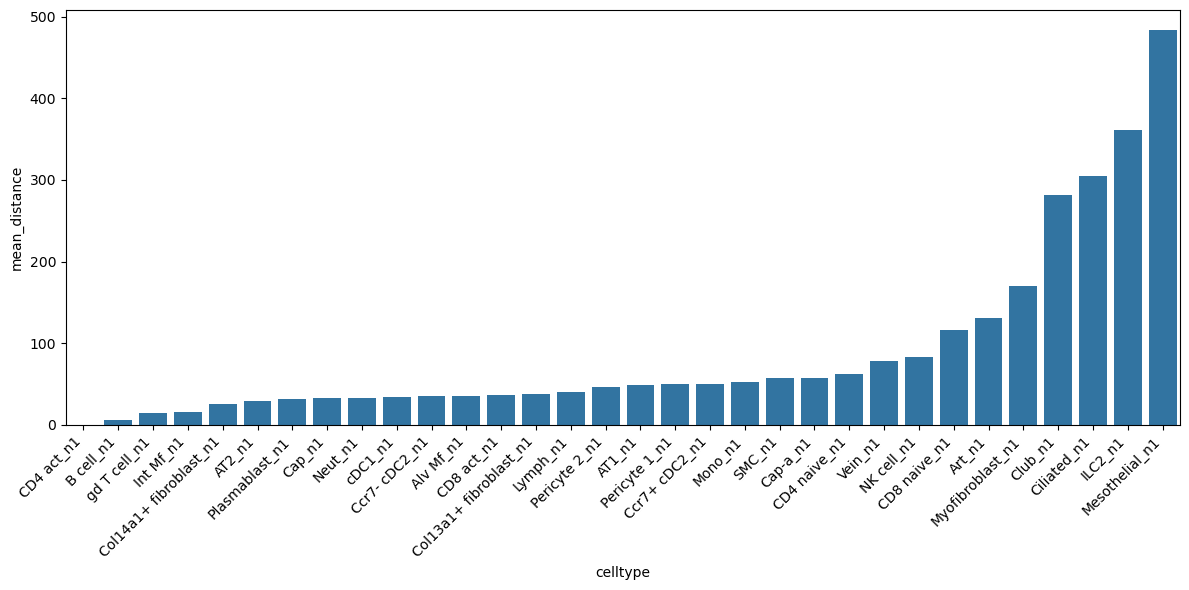

In [119]:
adata_sample_cd4 = adata_sample[adata_sample.obs['label_medium']=='CD4 act', :]

group_by = ['label_for_int', 'zone_consol']
summary_cd4 = (
    adata_sample_cd4.obs[group_by + distance_cols]
    .groupby(group_by)
    .agg('mean')  # or .agg(np.mean)
    .reset_index()
)
summary

summary_cd4 = summary_cd4[summary_cd4['zone_consol']=='TLS']
summary_cd4

# normalize
numeric_cols = [col for col in summary_cd4.columns if col not in group_by]

# Column-normalize only the numeric part
col_sums = summary_cd4[numeric_cols].sum(axis=0)
normalized_numeric = summary_cd4[numeric_cols].div(col_sums, axis=1)

# Combine back with categorical columns
summary_cd4_norm = pd.concat([summary_cd4[group_by], normalized_numeric], axis=1)


summary_melt = summary_cd4.melt(id_vars='label_for_int', 
                           value_vars=distance_cols, 
                           var_name='celltype', 
                           value_name='mean_distance')
summary_melt['celltype'] = summary_melt['celltype'].str.replace('avg_distance_to_', '')
summary_melt
summary_melt = summary_melt.sort_values(by='mean_distance')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_melt, x='celltype', y='mean_distance')
plt.xticks(rotation=45, ha='right')
# plt.title(f'Mean distance to other cell types\n(label_for_int = {label_of_interest})')
# plt.ylim(0,100)
plt.tight_layout()
plt.show()



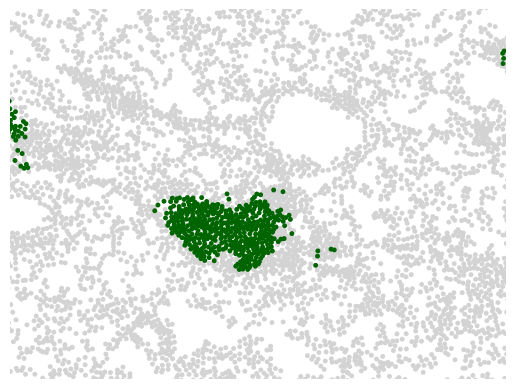

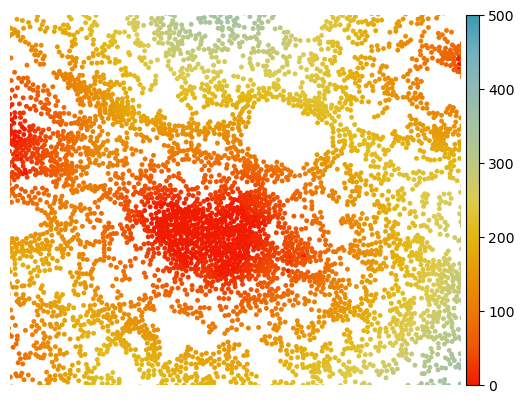

In [162]:
sample_label = 'HDM_day3'
adata_plot = adata_d3.copy()
adata_plot.obs['zone_consol_temp'] = adata_plot.obs['zone_consol'].copy()
adata_plot.obs.loc[adata_plot.obs['zone_consol'] != 'TLS', 'zone_consol_temp'] = np.nan
sc.pl.embedding(adata_plot, basis='spatial', color='zone_consol_temp',
                palette = zone_consol_palette_mapped,
                frameon=False, 
                size=50, 
                title = '',
                legend_loc = 'none',
                show=False)
# # overlay poly - tls
# ax = plt.gca()
# poly = joblib.load(os.path.join(dist_out_dir, 'tls_poly_' + sample_label + '.pkl'))
# for p in poly.geoms:
#         ax.plot(*p.exterior.xy, c='black', linewidth=5, alpha = 1)
   
plt.xlim([3700, 4400])
plt.ylim([4200, 4900])
plt.savefig(os.path.join(plot_out_dir, "zone_day3_tls_zoom.png"), dpi=300, bbox_inches='tight', transparent=True)

sc.pl.embedding(adata_d3, basis='spatial', 
                color='avg_distance_to_TLS_zone',
                # color='distance_to_tls',
                cmap = colormap_r,
                vmax=500,
                frameon=False, 
                size=50, 
                title = '',
                show=False)
# # overlay poly - tls
# ax = plt.gca()
# poly = joblib.load(os.path.join(dist_out_dir, 'tls_poly_' + sample_label + '.pkl'))
# for p in poly.geoms:
#         ax.plot(*p.exterior.xy, c='black', linewidth=5, alpha = 1)
    
plt.xlim([3700, 4400])
plt.ylim([4200, 4900])
plt.savefig(os.path.join(plot_out_dir, "distance_day3_tls_zoom.png"), dpi=300, bbox_inches='tight', transparent=True)

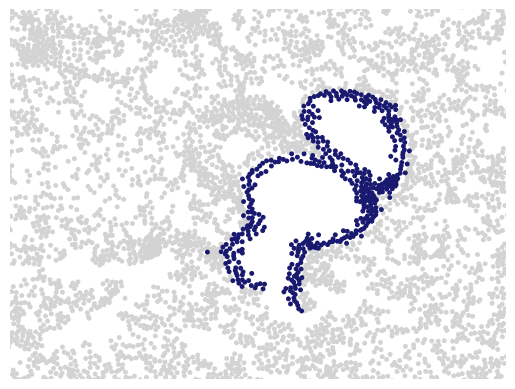

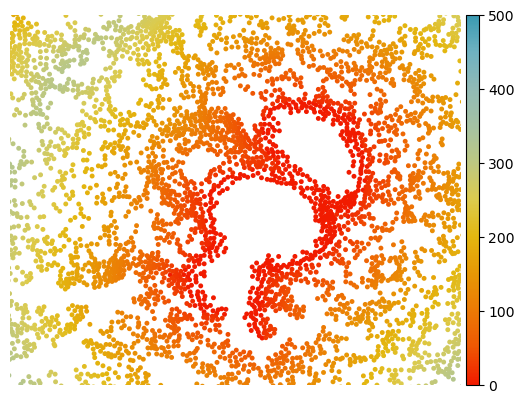

In [72]:
adata_plot = adata_d3.copy()
adata_plot.obs['zone_consol_temp'] = adata_plot.obs['zone_consol'].copy()
adata_plot.obs.loc[adata_plot.obs['zone_consol'] != 'bronchi', 'zone_consol_temp'] = np.nan
sc.pl.embedding(adata_plot, basis='spatial', color='zone_consol_temp',
                palette = zone_consol_palette_mapped,
                frameon=False, 
                size=50, 
                title = '',
                legend_loc = 'none',
                show=False)
    
plt.xlim([3150, 3900])
plt.ylim([2850, 3600])
plt.savefig(os.path.join(plot_out_dir, "zone_day3_bronchi_zoom.png"), dpi=300, bbox_inches='tight', transparent=True)

sc.pl.embedding(adata_d3, basis='spatial', color='avg_distance_to_bronchi_zone',
                cmap = colormap_r,
                vmax=500,
                frameon=False, 
                size=50, 
                title = '',
                show=False)
    
plt.xlim([3200, 3900])
plt.ylim([2900, 3600])
plt.savefig(os.path.join(plot_out_dir, "distance_day3_bronchi_zoom.png"), dpi=300, bbox_inches='tight', transparent=True)

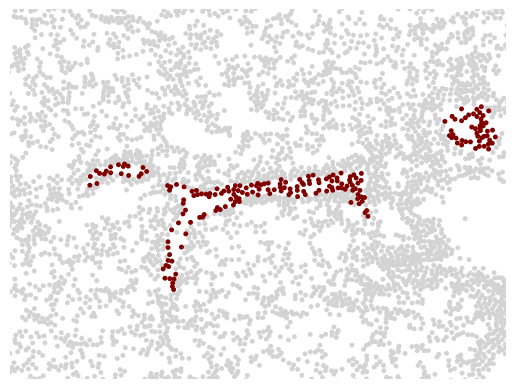

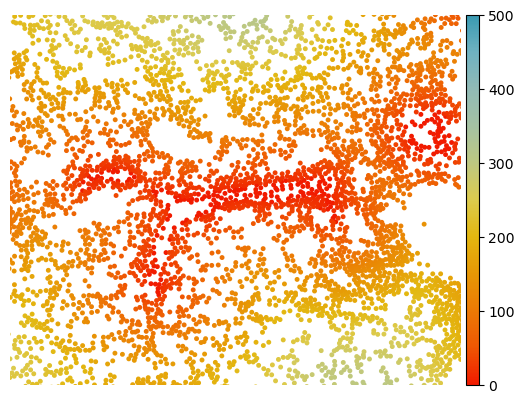

In [73]:
adata_plot = adata_d3.copy()
adata_plot.obs['zone_consol_temp'] = adata_plot.obs['zone_consol'].copy()
adata_plot.obs.loc[adata_plot.obs['zone_consol'] != 'vessels', 'zone_consol_temp'] = np.nan
sc.pl.embedding(adata_plot, basis='spatial', color='zone_consol_temp',
                palette = zone_consol_palette_mapped,
                frameon=False, 
                size=50, 
                title = '',
                legend_loc = 'none',
                show=False)
    
plt.xlim([4100, 4800])
plt.ylim([3500, 4200])
plt.savefig(os.path.join(plot_out_dir, "zone_day3_vessels_zoom.png"), dpi=300, bbox_inches='tight', transparent=True)

sc.pl.embedding(adata_d3, basis='spatial', color='avg_distance_to_vessels_zone',
                cmap = colormap_r,
                vmax=500,
                frameon=False, 
                size=50, 
                title = '',
                show=False)
    
plt.xlim([4100, 4800])
plt.ylim([3500, 4200])
plt.savefig(os.path.join(plot_out_dir, "distance_day3_vessels_zoom.png"), dpi=300, bbox_inches='tight', transparent=True)